In [1]:
# 必要なパッケージを呼び出す
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,tol,maxiter):

        # カリブレーション
        self.beta = beta              # 割引因子
        self.gamma = gamma            # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        self.alpha = alpha            # 資本分配率 
        self.delta = delta            # 固定資本減耗(delta=1.0のときは解析解が存在)  

        # 定常状態の値
        self.ykss = ykss
        self.kss = kss
        self.yss = yss
        self.css = css

        # グリッドに関するパラメータ
        self.kmax = kmax              # 資本グリッドの最大値
        self.kmin = kmin              # 資本グリッドの最小値
        self.nk = nk                  # グリッドの数
        self.kgrid = kgrid            # 資本グリッド

        # 時間反復法に関するパラメータ
        self.maxiter = maxiter        # 繰り返し計算の最大値
        self.tol = tol                # 許容誤差

In [3]:
def mu_CRRA(cons, gamma):
        """
        --------------------------------------
        === CRRA Marginal Utility Function ===
        --------------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        <output>
        ・consとgamma の下での限界効用水準
        """
        
        mu = cons ** (-gamma)
        return mu


In [4]:
def EulerEq(m,cons,capital,cfcn):
    """
    ----------------------------------------------
    === オイラー方程式に代入した際の残差を返す関数 ===
    ----------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・cons: 今期の消費量
    ・capital: 今期の資本保有量
    ・cfcn: 消費関数
    <output>
    ・res: オイラー方程式に代入した際の残差
    """

    wealth = capital**m.alpha + (1-m.delta)*capital
    kprime = wealth - cons

    #トリック:k'は正の値しか取らない
    kprime = max(m.kgrid[0],kprime) 

    # 次期の政策関数を線形補間
    c_interp = interp1d(m.kgrid,cfcn, kind="linear")
    cnext = c_interp(kprime)

    # オイラー方程式の残差を求める（u'(c)をmu_CRRA関数を用いて計算している）
    res = mu_CRRA(cons,m.gamma) - m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime**(m.alpha-1) + (1 - m.delta))

    return res

In [5]:
# メインファイル

# カリブレーション
beta = 0.96  # 割引因子
gamma = 1.0  # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40 # 資本分配率
delta = 1.0  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha
kss = ykss**(1.0/(alpha-1.0))
yss = ykss*kss
css = yss-delta*kss

# グリッドに関するパラメータ
kmax = 0.5   # 資本グリッドの最大値
kmin = 0.05  # 資本グリッドの最小値

# STEP 1(a): グリッド生成
nk = 21      # グリッドの数
kgrid = np.linspace(kmin,kmax,nk)

# 時間反復法に関するパラメータ
maxiter = 1000 # 繰り返し計算の最大値
tol = 1e-8     # 許容誤差(STEP2)

In [6]:
# 収束の基準に関するパラメータ
it = 1         # ループ・カウンター
dif2 = 1.0     # 政策関数の繰り返し誤差
tolfun = 1e-10 # newtonのオプション(最適化の許容誤差)

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,tol,maxiter)

start = time.time()

print("")
print("-+- Solve a neoclassical growth model with time iteration -+-")
print("")

# STEP 1(b): 政策関数の初期値を当て推量 
# 政策関数の初期化
cfcn0 = np.copy(m.kgrid)
cfcn1 = np.zeros(m.nk)

# 繰り返し誤差を保存する変数を設定 
dif = np.zeros((2,m.maxiter))

# STEP 4: 政策関数を繰り返し計算
while (it < m.maxiter) & (dif2 > m.tol):

    for i in range(m.nk):

        capital = m.kgrid[i]
        wealth = (capital**m.alpha) + (1.0-m.delta)*capital

        # Pythonの最適化関数(fsolve)を使って各グリッド上の政策関数の値を探す
        # 最適化の初期値は古い政策関数の値
        Euler = lambda x: EulerEq(m,x,capital,cfcn0)
        cons = fsolve(Euler,x0=cfcn0[i],xtol=tolfun)
        cfcn1[i] = cons
        kprime = wealth-cons

    # 繰り返し計算誤差を確認
    dif2 = np.max(np.abs(cfcn1-cfcn0))
    
    # 収束途中の繰り返し計算誤差を保存
    dif[1,it] = np.copy(dif2)

    # 政策関数をアップデート
    cfcn0 = np.copy(cfcn1)

    # 繰り返しの結果を表示
    print(f"iteration index: {it}")
    print(f"policy function iteration error: {dif2:.8f}")

    it += 1 


end = time.time() - start
print("")
print(f"{end:.6f} seconds")
print("")


-+- Solve a neoclassical growth model with time iteration -+-

iteration index: 1
policy function iteration error: 0.09823124
iteration index: 2
policy function iteration error: 0.03163744
iteration index: 3
policy function iteration error: 0.01135434
iteration index: 4
policy function iteration error: 0.00551848
iteration index: 5
policy function iteration error: 0.00231934
iteration index: 6
policy function iteration error: 0.00092346
iteration index: 7
policy function iteration error: 0.00036240
iteration index: 8
policy function iteration error: 0.00013966
iteration index: 9
policy function iteration error: 0.00005345
iteration index: 10
policy function iteration error: 0.00002042
iteration index: 11
policy function iteration error: 0.00000780
iteration index: 12
policy function iteration error: 0.00000298
iteration index: 13
policy function iteration error: 0.00000114
iteration index: 14
policy function iteration error: 0.00000043
iteration index: 15
policy function iteration err

In [7]:
# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 =  (m.kgrid**m.alpha) + (1.0-m.delta)*m.kgrid - cfcn0 

# 解析的解(for k'=g(k))
p_true = m.beta*m.alpha*(m.kgrid**m.alpha)

mu_CRRA_vec = np.vectorize(mu_CRRA)

# オイラー方程式から誤差を測定
# 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる

kgrid_err = np.linspace(m.kmin,m.kmax,(m.nk-1)*10+1)
# c=h(k;b)の値を線形補間
cons_interp = interp1d(m.kgrid,cfcn0,kind="linear",fill_value="extrapolate")
cons = cons_interp(kgrid_err)
LHS = mu_CRRA_vec(cons,m.gamma)

# k'=f(k)-c
kp = (kgrid_err**m.alpha) + (1.0-m.delta)*kgrid_err - cons

# c'=h(k';b)の値を線形補間
cnext = cons_interp(kp)
rent = m.alpha*(kp**(m.alpha-1.0)) - m.delta
RHS = m.beta*(1.0+rent) * mu_CRRA_vec(cnext,m.gamma)

err = (RHS/LHS) - 1.0

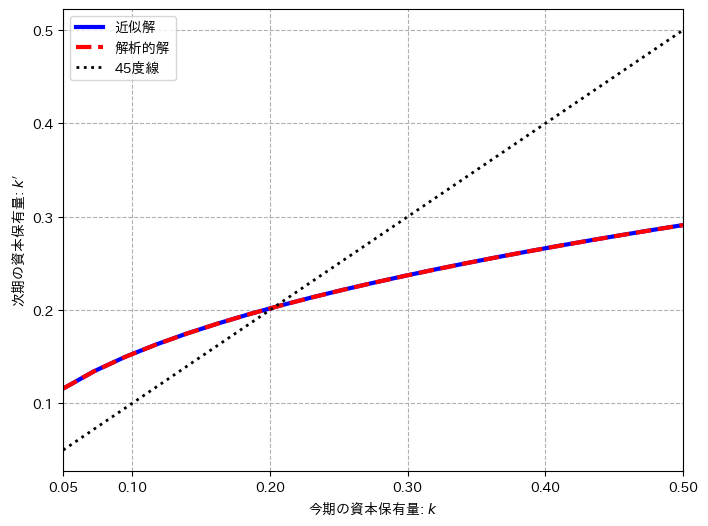

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(m.kgrid,pfcn0,c="b",lw=3,label="近似解")
ax.plot(m.kgrid,p_true,c="r",lw=3,ls="--",label="解析的解")
ax.plot(m.kgrid,m.kgrid,c="k",lw=2,ls=":",label="45度線")
ax.set(xlabel="今期の資本保有量: $k$",ylabel="次期の資本保有量: $k'$",xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5])
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.savefig("Fig_pti2.pdf")
plt.show()

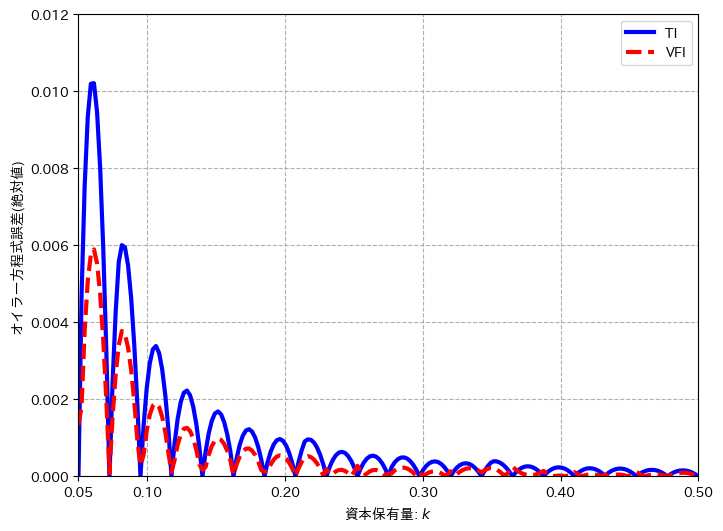

In [9]:
f = open("err_ndp.csv",encoding='utf-8-sig')
err2 = np.loadtxt(f) #VFIでのオイラー方程式誤差

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(kgrid_err,np.abs(err),c="b",lw=3,label="TI")
ax.plot(kgrid_err,np.abs(err2),c="r",lw=3,ls="--",label="VFI")
ax.set(xlabel="資本保有量: $k$",ylabel="オイラー方程式誤差(絶対値)",xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5],ylim=(0.0,0.012))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.savefig("Fig_pti6.pdf")
plt.show()